In [ ]:
# Exploring the Galaxy Halo connection of a MW-M31 merger remanent.
# Checking the stellar mass to halo mass relation of the MW-M31 merger remanent.
# The code will calculate the SHMR using the Moster et al. (2013) relation.

In [25]:
# import the needed stuff
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.constants import G
from ReadFile import Read
from CenterOfMass2 import CenterOfMass
from matplotlib.colors import LogNorm
import scipy.optimize as so


In [3]:
MW = np.genfromtxt("Orbit_MW.txt", comments='#', names=True)
M31 = np.genfromtxt("Orbit_M31.txt", comments='#', names=True)
M33 = np.genfromtxt("Orbit_M33.txt", comments='#', names=True)

In [5]:
# function to compute the magnitude of the difference between two vectors 
# You can use this function to return both the relative position and relative velocity for two 
# galaxies over the entire orbit  
def relative_mag(galaxy_1, galaxy_2):
    """Calculate the relative position and relative velocity of the galaxies
    
    Inputs:
    galaxy_1: the name of the first galaxy
    galaxy_2: the name of the second galaxy     
    
    Returns:
    relative_position: the relative position of the two galaxies
    relative_velocity: the relative velocity of the two galaxies
    """
    # Calculate the relative position and relative velocity of the two galaxies
    relative_position = np.sqrt((galaxy_1["x"] - galaxy_2["x"])**2 + (galaxy_1["y"] - galaxy_2["y"])**2 + (galaxy_1["z"] - galaxy_2["z"])**2)
    relative_velocity = np.sqrt((galaxy_1["vx"] - galaxy_2["vx"])**2 + (galaxy_1["vy"] - galaxy_2["vy"])**2 + (galaxy_1["vz"] - galaxy_2["vz"])**2)

    return relative_position, relative_velocity

    
rel_pos_MW_M31, rel_vel_MW_M31 = relative_mag(MW, M31)


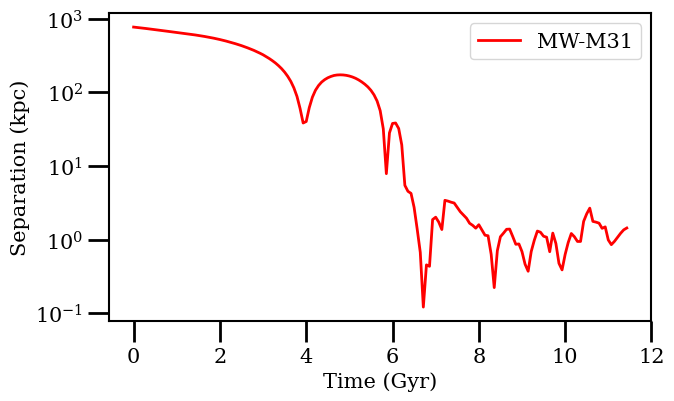

In [ ]:
plt.rcParams.update({
    "font.family": "DejaVu Serif",   # specify font family here
    "font.serif": ["cm"],
    "mathtext.fontset" : "dejavuserif" ,
    "font.size":17,
    "axes.titlesize" : 20,
    "axes.labelsize" : 20,
    "axes.linewidth" : 1.5,
    "lines.linewidth" : 2.0,
    "xtick.labelsize" :15,
    "ytick.labelsize" : 15,
    "xtick.major.size" : 15,
    "xtick.minor.size" : 0,
    "ytick.major.size" : 15,
    "ytick.minor.size" : 0,
    "xtick.major.width" : 2,
    "xtick.minor.width" : 2,
    "ytick.major.width" : 2,
    "ytick.minor.width" : 2})  
plt.rcParams["legend.frameon"] = True
fig= plt.figure(figsize=(7,4))

plt.semilogy(MW["t"], rel_pos_MW_M31, label='MW-M31', color='red')

plt.xlabel('Time (Gyr)', fontsize=15)
plt.ylabel('Separation (kpc)', fontsize=15)

plt.legend(loc='upper right', fontsize=15)


In [12]:
# finding the snapshot time when the MW and M31 are closest
# Find the index of the minimum separation
min_index = np.argmin(rel_pos_MW_M31)
# Find the minimum separation time
min_time = MW["t"][min_index]
min_time

6.714

In [14]:
# finding the snapshot time when the MW and M31 are closest
time_per_snapshot = 14.28570e-3 # in Gyr

snapshot_number = int(min_time / time_per_snapshot)
snapshot_number

469

## Plotting the density plot of the halo and disk particles at the above snapshot time


In [46]:
# Code for plotting contours
# from https://gist.github.com/adrn/3993992


def find_confidence_interval(x, pdf, confidence_level):
    return pdf[pdf > x].sum() - confidence_level

def density_contour(xdata, ydata, nbins_x, nbins_y, ax=None, **contour_kwargs):
    """ Create a density contour plot.
    Parameters
    ----------
    xdata : numpy.ndarray
    ydata : numpy.ndarray
    nbins_x : int
        Number of bins along x dimension
    nbins_y : int
        Number of bins along y dimension
    ax : matplotlib.Axes (optional)
        If supplied, plot the contour to this axis. Otherwise, open a new figure
    contour_kwargs : dict
        kwargs to be passed to pyplot.contour()
        
    Example Usage
    -------------
     density_contour(x pos, y pos, contour res, contour res, axis, colors for contours)
     e.g.:
     density_contour(xD, yD, 80, 80, ax=ax, 
         colors=['red','orange', 'yellow', 'orange', 'yellow'])

    """

    H, xedges, yedges = np.histogram2d(xdata, ydata, bins=(nbins_x,nbins_y), density=True)
    # NOTE : if you are using the latest version of python, in the above: 
    # instead of normed=True, use density=True
    
    x_bin_sizes = (xedges[1:] - xedges[:-1]).reshape((1,nbins_x))
    y_bin_sizes = (yedges[1:] - yedges[:-1]).reshape((nbins_y,1))

    pdf = (H*(x_bin_sizes*y_bin_sizes))
    
    X, Y = 0.5*(xedges[1:]+xedges[:-1]), 0.5*(yedges[1:]+yedges[:-1])
    Z = pdf.T
    fmt = {}
    
    ### Adjust Here #### 
    
    # Contour Levels Definitions
    one_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.68))
    two_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.80))
    three_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.95))
    four_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.97))
    five_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.99))


    print(four_sigma)

    # Array of Contour levels. Adjust according to the above
    levels = [one_sigma,two_sigma, three_sigma, four_sigma, five_sigma][::-1]
    
    # contour level labels  Adjust accoding to the above.
    strs = ['0.68','0.80','0.95', '0.97','0.99'][::-1]

    
    ###### 
    
    if ax == None:
        contour = plt.contour(X, Y, Z, levels=levels, origin="lower", **contour_kwargs)
        for l, s in zip(contour.levels, strs):
            fmt[l] = s
        plt.clabel(contour, contour.levels, inline=True, fmt=fmt, fontsize=12)

    else:
        contour = ax.contour(X, Y, Z, levels=levels, origin="lower", **contour_kwargs)
        for l, s in zip(contour.levels, strs):
            fmt[l] = s
        ax.clabel(contour, contour.levels, inline=True, fmt=fmt, fontsize=12)
    
    return contour

In [76]:
# Create a COM of object for M31 Disk (particle type=2) Using Code from Homework 4
COMD = CenterOfMass("/Users/swapnaneeldey/Desktop/ASTR400Bfiles/M31/M31_469.txt",2)

# Compute COM of M31 using disk particles
COMP = COMD.COM_P(0.1,2)
COMV = COMD.COM_V(COMP[0],COMP[1],COMP[2])
# Determine positions of disk particles relative to COM 
xD_M31 = COMD.x - COMP[0].value 
yD_M31  = COMD.y - COMP[1].value 
zD_M31  = COMD.z - COMP[2].value 


In [77]:
# Create a COM of object for M31 Disk (particle type=2) Using Code from Homework 4
COMD = CenterOfMass("/Users/swapnaneeldey/Desktop/ASTR400Bfiles/MW/MW_469.txt",2)

# Compute COM of M31 using disk particles
COMP = COMD.COM_P(0.1,2)
COMV = COMD.COM_V(COMP[0],COMP[1],COMP[2])
# Determine positions of disk particles relative to COM 
xD_MW = COMD.x - COMP[0].value 
yD_MW = COMD.y - COMP[1].value 
zD_MW = COMD.z - COMP[2].value 


In [78]:
xD = np.concatenate((xD_MW, xD_M31))
yD = np.concatenate((yD_MW, yD_M31))
zD = np.concatenate((zD_MW, zD_M31))

8.000000009984794e-05
0.00011666666636817289


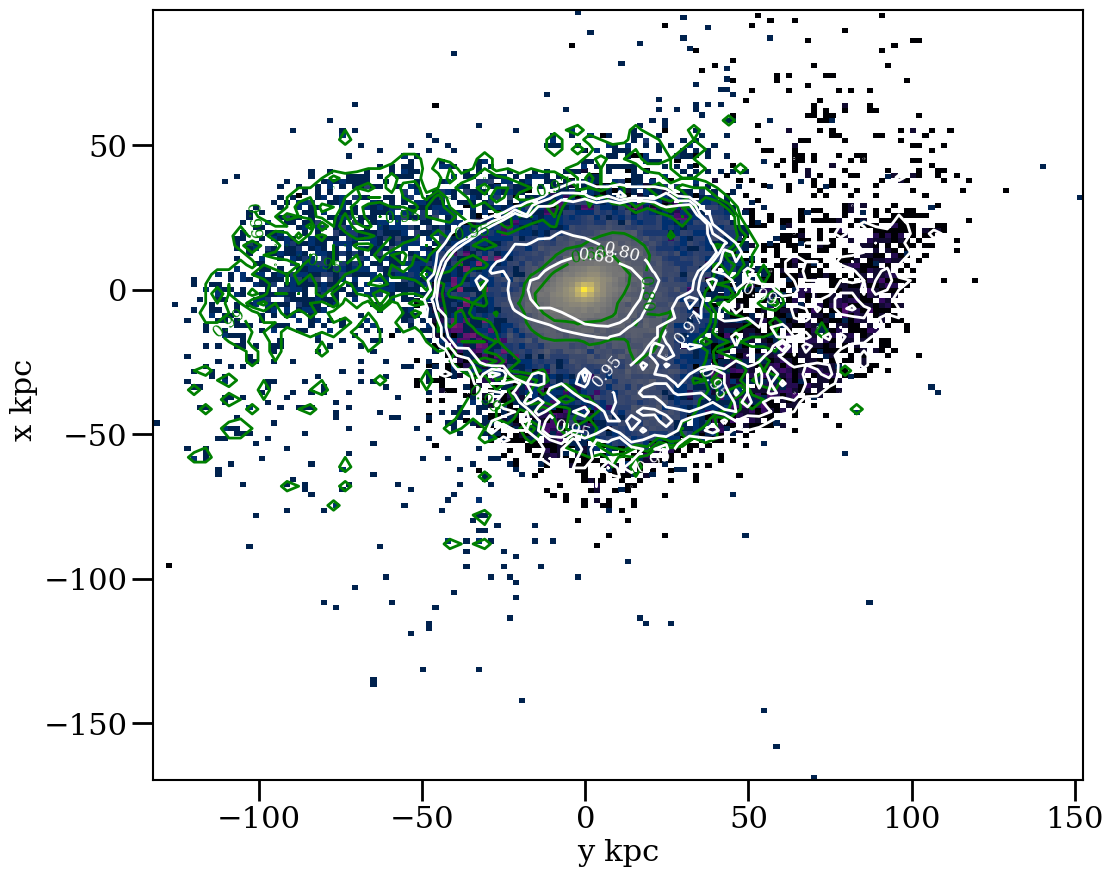

In [88]:
# 1) Make plots 

# M31 Disk Density 
fig, ax= plt.subplots(figsize=(12, 10))

# ADD HERE
# plot the particle density for M31 using a 2D historgram
#plt.hist2D(pos1,pos2, bins=, norm=LogNorm(), cmap='' )
# cmap options: 
# https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html  
#   e.g. 'magma', 'viridis'
# can modify bin number to make the plot smoother

plt.hist2d(xD_M31, yD_M31, bins=150, norm=LogNorm(), cmap='inferno')
plt.hist2d(xD_MW, yD_MW, bins=150, norm=LogNorm(), cmap='cividis')


"""cbar = plt.colorbar()
cbar.set_label("Number of disk particle per bin", fontsize=15)"""

# ADD HERE
# make the contour plot
# x pos, y pos, contour res, contour res, axis, colors for contours.
# remember to adjust this if there are other contours added
# density_contour(pos1, pos2, res1, res2, ax=ax, colors=[])

contour1 = density_contour(xD_MW, yD_MW, 80, 80, ax=ax, colors=['g'])
contour2 = density_contour(xD_M31, yD_M31, 80, 80, ax=ax, colors=['w'])

# Add axis labels
plt.xlabel("y kpc", fontsize=22)
plt.ylabel('x kpc ', fontsize=22)


#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size



# Save to a file
#plt.savefig('/Users/swapnaneeldey/Desktop/ASTR400Bfiles/ASTR400B/Labs/Lab7/Lab7_M31Disk.png')

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-9316.59      , -9184.01246667, -9051.43493333, -8918.8574    ,
        -8786.27986667, -8653.70233333, -8521.1248    , -8388.54726667,
        -8255.96973333, -8123.3922    , -7990.81466667, -7858.23713333,
        -7725.6596    , -7593.08206667, -7460.50453333, -7327.927     ,
        -7195.34946667, -7062.77193333, -6930.1944    , -6797.61686667,
        -6665.03933333, -6532.4618    , -6399.88426667, -6267.30673333,
        -6134.7292    , -6002.15166667, -5869.57413333, -5736.9966    ,
        -5604.41906667, -5471.84153333, -5339.264     , -5206.68646667,
        -5074.10893333, -4941.5314    , -4808.95386667, -4676.37633333,
        -4543.7988    , -4411.22126667, -4278.64373333, -4146.0662    ,
        -4013.48866667, -3880.9

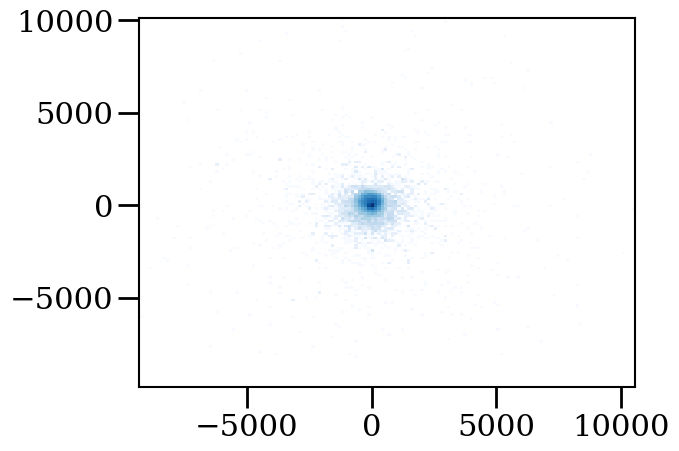

In [ ]:
plt.hist2d(xD_MW, yD_MW, bins=150, norm=LogNorm(), cmap='Blues')

In [69]:
def find_max_x_in_contour(xdata, ydata, nbins_x, nbins_y, sigma_level="four_sigma"):
    """
    Find the maximum x value that falls within a specific confidence contour level.
    
    Parameters
    ----------
    xdata : numpy.ndarray
        x-coordinates of data points
    ydata : numpy.ndarray
        y-coordinates of data points
    nbins_x : int
        Number of bins along x dimension
    nbins_y : int
        Number of bins along y dimension
    sigma_level : str, optional
        The confidence level to use ("one_sigma", "two_sigma", etc.)
        
    Returns
    -------
    float
        Maximum x value within the specified contour
    """
    # Create the 2D histogram
    H, xedges, yedges = np.histogram2d(xdata, ydata, bins=(nbins_x, nbins_y), density=True)
    
    # Calculate the bin sizes
    x_bin_sizes = (xedges[1:] - xedges[:-1]).reshape((1, nbins_x))
    y_bin_sizes = (yedges[1:] - yedges[:-1]).reshape((nbins_y, 1))
    
    # Calculate the PDF
    pdf = (H * (x_bin_sizes * y_bin_sizes))
    
    # Get the bin centers
    X, Y = 0.5*(xedges[1:] + xedges[:-1]), 0.5*(yedges[1:] + yedges[:-1])
    Z = pdf.T
    
    # Calculate contour levels
    one_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.68))
    two_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.80))
    three_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.95))
    four_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.97))
    five_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.99))
    
    # Get the threshold value based on sigma_level
    sigma_values = {
        "one_sigma": one_sigma,
        "two_sigma": two_sigma,
        "three_sigma": three_sigma,
        "four_sigma": four_sigma,
        "five_sigma": five_sigma
    }
    
    threshold = sigma_values[sigma_level]
    
    # Find all points where PDF is above the threshold
    # These points are within the contour
    in_contour = Z >= threshold
    
    # Get the x-values of points within the contour
    x_in_contour = X[np.any(in_contour, axis=0)]
    
    # If no points are in the contour, return None
    if len(x_in_contour) == 0:
        return None
    
    # Return the maximum x value within the contour
    return np.max(x_in_contour)

In [70]:
max_x_in_4sigma = find_max_x_in_contour(xD, yD, 80, 80, "four_sigma")
print(f"Maximum x value within 4-sigma contour: {max_x_in_4sigma}")

Maximum x value within 4-sigma contour: 3091.8158125
